# Analyzing Liège Microgrid data

## Data source

Data was obtained from the following link:
https://www.kaggle.com/jonathandumas/liege-microgrid-open-data


## Associated Paper

#### Paper title: Coordination of Operational Planning (OP) and Real time Optimization (RTO) in Microgrids

Some details:

###### Day-ahead Forecast -------->  OP ----->  Optimize total energy cost, revenues, peak consumption, injection costs, reserve planning

###### Day-ahead Forecast - Actual measurement = Forecast Errors

###### Forecast Errors ------> RTO ------> Implementable action

#### OP ----> Paper ----> RTO

## Data set
- Climate model weather forecast (Resolution: 15 mins)
- Monitoring of PV and Consumption of Microgrid MiRIS (Resolution: 5 sec)
- Forecast of PV and Consumption used in the paper using RNN and GBR (Resolution: 15 mins)

The weather based forecasts are multi outputs with an horizon of 24 hours ahead and a resolution of 15 minutes. They are quarterly produced on rolling basis with a learning set of one week. Every six hours the model is refreshed and the learning set is moved consequently.
This means, each quarter a PV and consumption forecast is produced, composed of 96 values (one per quarter of the 24 hours ahead). 

## Model description
Two "classic" deterministic techniques are implemented, a Recurrent Neural Network(RNN) with the keras python library and a Gradient Boosting Regression (GBR) with the scikit-learn python library.

The RNN is a LSTM with one hidden layer, 5000 epochs, RELU as activation function (hidden layer and output), a batch size of 200 and drop out rate of 0.4.

The GBR is the multi output GBR of sklearn with 200 estimator and 20 as max depth.




# Tasks to try
The following are some tasks we think of trying as we venture into analyzing this.

### 1. Prepare data that is synchronous with time
Weather: 10-May to 18-June
RNN/GBR Forecast (PV/Load):  20-May to 17-June
MiRIS data (PV/Load):  13-May to 21-June

Bring all data to between 20-May to 17-June

### 2. Reconciling Sampling rate
Weather forecast and forecast by ML models: 15 min
MiRIS data: 5 seconds
- Drop ?
- Average?

### 3. Other data pre-treatment
- Do we need look-ahead prediction
- Do we use only RNN forecast?

### 4. Explore the relationship between the weather and the MiRIS data
- How does cloud cover affect MiRIS production?
- How about surface temperature?

###### Which of the following factors are useful?
    CD = low clouds (0 to 1)
    CM = medium clouds (0 to 1)
    CU = high clouds (0 to 1)
    PREC = precipitation (mm / 15 min)
    RH2m = relative humidity (%)
    SNOW = snow height (mm)
    ST = Surface Temperature (°C)
    SWD = Global Horizontal Irradiance (W/m2)
    SWDtop = Total Solar Irradiance at the top of the atmosphere (W/m2)
    TT2M = temperature 2 meters above the ground (°C)
    WS100m = Wind speed at 100m from the ground (m/s)
    WS10m = Wind speed at 10m from the ground (m/s)

### 5. How does the RNN prediction compare with real data
- Does is do well at some point and not at other points? 
- Is there some weather or temporal indicators on when RNN does not do well?
- Does the look-ahead predictors improve anything?



Importing relevant modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Basic File handling to get data

`unzip` the zip file. We assume in the following that the zip file has been unzipped.

We use the OS module to list and analyze the files in the directory

In [2]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./') if isfile(join('./', f))]

In [3]:
onlyfiles

['324423_651523_bundle_archive.zip',
 'Liege_Microgrid_EDA.ipynb',
 'load_15min_forecast_gbr_20_200.csv',
 'load_15min_forecast_rnn_1_5000.csv',
 'miris_load.csv',
 'miris_pv.csv',
 'pv_15min_forecast_gbr_20_200.csv',
 'pv_15min_forecast_rnn_1_5000.csv',
 'weather_data.csv']

The above contains both csv, zip and the ipython file. We would construct a list of only the CSVs

In [4]:
onlycsv = []
for file in onlyfiles:
    filetype = file.split('.')[-1]
    if filetype == 'csv':
        onlycsv.append(file)
print(onlycsv)

['load_15min_forecast_gbr_20_200.csv', 'load_15min_forecast_rnn_1_5000.csv', 'miris_load.csv', 'miris_pv.csv', 'pv_15min_forecast_gbr_20_200.csv', 'pv_15min_forecast_rnn_1_5000.csv', 'weather_data.csv']


Once the CSV files have been separated, we load them all in  a dictionary of pandas array with the keys being the file names

In [5]:
df_all_data = {}
for x in onlycsv:
    df_all_data[x] = pd.read_csv(x)

In [6]:
df_all_data.keys()

dict_keys(['load_15min_forecast_gbr_20_200.csv', 'load_15min_forecast_rnn_1_5000.csv', 'miris_load.csv', 'miris_pv.csv', 'pv_15min_forecast_gbr_20_200.csv', 'pv_15min_forecast_rnn_1_5000.csv', 'weather_data.csv'])

Our inital focus will be to analyze the correlation between the weather data and the PV generation. So we get them in separate data frames

In [7]:
df_weather = df_all_data['weather_data.csv']

In [8]:
df_pv = df_all_data['miris_pv.csv']

## Time is an illusion. Let's make it not so.
Well, in the data frame the time is appearing as a string with details that are not pertinent. In the following, we wrestle with time.

In [9]:
newstr = df_weather['Time'].iloc[0] #[:-6]
newstr.split('+')[0].split('T')
' '.join(newstr.split('+')[0].split('T'))

'2019-05-10 00:00:00'

Now that we know how time is represented, we created a function (or a lambda function) to convert the time in string to a Python datetime object.

In [10]:
def time_proc(x):
    return datetime.strptime(' '.join(x.split('+')[0].split('T')), '%Y-%m-%d %H:%M:%S')

In [11]:
time_proc = lambda x: datetime.strptime(' '.join(x.split('+')[0].split('T')), '%Y-%m-%d %H:%M:%S')

In [12]:
df_weather['Time'].apply(time_proc)

0      2019-05-10 00:00:00
1      2019-05-10 00:15:00
2      2019-05-10 00:30:00
3      2019-05-10 00:45:00
4      2019-05-10 01:00:00
               ...        
3740   2019-06-17 23:00:00
3741   2019-06-17 23:15:00
3742   2019-06-17 23:30:00
3743   2019-06-17 23:45:00
3744   2019-06-18 00:00:00
Name: Time, Length: 3745, dtype: datetime64[ns]

So it looks fine and so we put this into a new column

In [13]:
df_weather['Time_DT'] = df_weather['Time'].apply(time_proc)

In [14]:
df_weather.head()

,Time,CD,CM,CU,PREC,RH2m,SNOW,ST,SWD,SWDtop,TT2M,WS100m,WS10m,Time_DT
0,2019-05-10T00:00:00+02:00,0.13,0.0,0.0,0.0,75.15,0,7.99,0.0,0,9.49,6.87,2.49,2019-05-10 00:00:00
1,2019-05-10T00:15:00+02:00,0.01,0.0,0.0,0.0,76.27,0,7.58,0.0,0,9.15,7.04,2.51,2019-05-10 00:15:00
2,2019-05-10T00:30:00+02:00,0.01,0.0,0.0,0.0,76.66,0,7.49,0.0,0,9.05,8.03,3.17,2019-05-10 00:30:00
3,2019-05-10T00:45:00+02:00,0.01,0.0,0.0,0.0,75.58,0,7.62,0.0,0,9.18,8.67,3.73,2019-05-10 00:45:00
4,2019-05-10T01:00:00+02:00,0.01,0.0,0.0,0.0,74.53,0,7.65,0.0,0,9.23,9.08,3.97,2019-05-10 01:00:00


In [15]:
df_pv['Time_DT'] = df_pv['DateTime'].apply(time_proc)

With the dates available in python datetime object, we can now proceed

## Synchronizing the available data
We observed that the dates of the data available were not equal and so chose the common availability between all data. The lower and upper cutoff dates determine that

In [16]:
low_cutoff_date = datetime(2019, 5, 19, 23,59,59)
upper_cutoff_date = datetime(2019, 6, 18, 0, 0, 0)

In [17]:
df_weather_synch = df_weather[(df_weather['Time_DT']>low_cutoff_date) & (df_weather['Time_DT']<upper_cutoff_date)]

In [18]:
df_pv_synch = df_pv[(df_pv['Time_DT']>low_cutoff_date) & (df_pv['Time_DT']<upper_cutoff_date)]

In [19]:
df_pv_synch

,DateTime,PV,Time_DT
120960,2019-05-20 00:00:00+00:00,0.0,2019-05-20 00:00:00
120961,2019-05-20 00:00:05+00:00,0.0,2019-05-20 00:00:05
120962,2019-05-20 00:00:10+00:00,0.0,2019-05-20 00:00:10
120963,2019-05-20 00:00:15+00:00,0.0,2019-05-20 00:00:15
120964,2019-05-20 00:00:20+00:00,0.0,2019-05-20 00:00:20
...,...,...,...
622075,2019-06-17 23:59:35+00:00,0.0,2019-06-17 23:59:35
622076,2019-06-17 23:59:40+00:00,0.0,2019-06-17 23:59:40
622077,2019-06-17 23:59:45+00:00,0.0,2019-06-17 23:59:45
622078,2019-06-17 23:59:50+00:00,0.0,2019-06-17 23:59:50


We would prefer the date time column actually becomes the index so that we can process data more easily across different data frames

In [20]:
df_pv_synch.set_index('Time_DT',inplace=True)
df_weather_synch.set_index('Time_DT',inplace=True)

In [21]:
df_pv_synch.head()

,DateTime,PV
Time_DT,,
2019-05-20 00:00:00,2019-05-20 00:00:00+00:00,0.0
2019-05-20 00:00:05,2019-05-20 00:00:05+00:00,0.0
2019-05-20 00:00:10,2019-05-20 00:00:10+00:00,0.0
2019-05-20 00:00:15,2019-05-20 00:00:15+00:00,0.0
2019-05-20 00:00:20,2019-05-20 00:00:20+00:00,0.0


 ## Synchronizing sampling rates
As was pointed out earlier, the PV and load measurement data are available every 5 seconds whereas others are available every 15 mins. We decided that 15 mins for all data is the best recourse.

The question is, what should we do about the data in between? Should we take the mean/sum/median/max ?
It would depend on the underlying data. In our case, we have a PV data which is the power generation and we would prefer to sum them up.

We use the `resample` method of a dataframe

In [23]:
df_pv_synch_downsampled = df_pv_synch.resample('15T').sum()

In [24]:
df_pv_synch_downsampled.iloc[48:55]

,PV
Time_DT,
2019-05-20 12:00:00,26.797277
2019-05-20 12:15:00,25.044575
2019-05-20 12:30:00,12.087250
2019-05-20 12:45:00,20.049474
2019-05-20 13:00:00,42.706529
2019-05-20 13:15:00,26.285650
2019-05-20 13:30:00,13.998160


We wil put the weather data together with the PV data and remove the Time column because it is now redundant

In [25]:
df_pv_weather = pd.concat([df_pv_synch_downsampled, df_weather_synch], axis=1)
del df_pv_weather['Time']

In [26]:
df_pv_weather.head()

,PV,CD,CM,CU,PREC,RH2m,SNOW,ST,SWD,SWDtop,TT2M,WS100m,WS10m
Time_DT,,,,,,,,,,,,,
2019-05-20 00:00:00,0.0,0.20,0.21,1.0,0.07,98.09,0,10.83,0.0,0,11.32,3.65,1.51
2019-05-20 00:15:00,0.0,0.88,0.70,1.0,0.05,98.00,0,11.30,0.0,0,11.58,3.82,1.49
2019-05-20 00:30:00,0.0,0.88,0.70,1.0,0.05,98.02,0,11.59,0.0,0,11.87,4.12,1.46
2019-05-20 00:45:00,0.0,0.88,0.70,1.0,0.06,98.44,0,11.73,0.0,0,11.99,4.21,1.43
2019-05-20 01:00:00,0.0,0.88,0.70,1.0,0.02,98.81,0,11.84,0.0,0,12.08,4.15,1.38


A quick recap of the columns 

CD = low clouds (0 to 1)
CM = medium clouds (0 to 1)
CU = high clouds (0 to 1)
PREC = precipitation (mm / 15 min)
RH2m = relative humidity (%)
SNOW = snow height (mm)
ST = Surface Temperature (°C)
SWD = Global Horizontal Irradiance (W/m2)
SWDtop = Total Solar Irradiance at the top of the atmosphere (W/m2)
TT2M = temperature 2 meters above the ground (°C)
WS100m = Wind speed at 100m from the ground (m/s)
WS10m = Wind speed at 10m from the ground (m/s)

There are too many cloud cover information. To simplify them, we can just say there is only a single cloud cover and that would be the maximum of the three types. In a very simplified view, this would mean that we don't care where the clouds are, they are clouds anyway. This is a bit naive but serves our purpose for now.

We use a lambda function to do that.

In [27]:
max_clouds = lambda x : max(x['CD'], x['CM'], x['CU'])
df_pv_weather['cloudcover'] = df_pv_weather.apply(max_clouds, axis=1)

(18040.0, 18046.0)

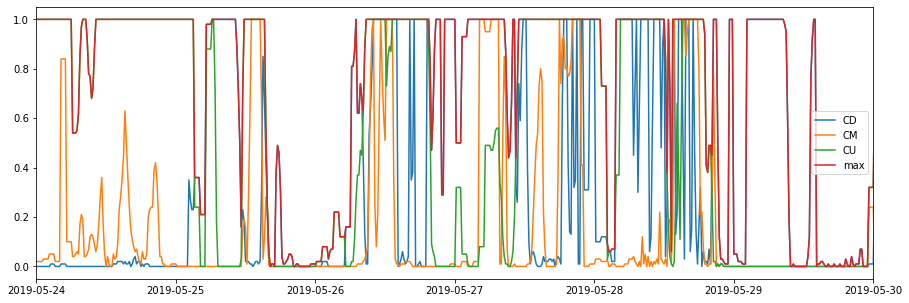

In [28]:
plt.figure(figsize=(15,5))
plt.plot(df_pv_weather['CD'],label='CD')
plt.plot(df_pv_weather['CM'],label='CM')
plt.plot(df_pv_weather['CU'],label='CU')
plt.plot(df_pv_weather['cloudcover'],label='max')
plt.legend()
plt.xlim(datetime(2019,5,24),datetime(2019,5,30))

Let's try to turn the cloud cover data into categorical ones

In [29]:
pd.Categorical(df_pv_weather.cloudcover, categories=[0.0,0.25,0.5,0.75,1.0])

[1.0, 1.0, 1.0, 1.0, 1.0, ..., NaN, NaN, 1.0, 1.0, 1.0]
Length: 2784
Categories (5, float64): [0.00, 0.25, 0.50, 0.75, 1.00]

This isn't working as intended due to the presence of NaN, etc. So we go about creating a function that can help us do it

In [30]:
def categorization_clouds(x):
    if x>=0.0 and x<0.25:
        return 0
    elif x>=0.25 and x<0.5:
        return 1
    elif x>=0.5 and x<0.75:
        return 2
    elif x>=0.75 and x<=1.0:
        return 3
    else:
        return 0

In [31]:
df_pv_weather['cloudcover_category'] = df_pv_weather['cloudcover'].apply(categorization_clouds)

In [32]:
df_pv_weather.head()

,PV,CD,CM,CU,PREC,RH2m,SNOW,ST,SWD,SWDtop,TT2M,WS100m,WS10m,cloudcover,cloudcover_category
Time_DT,,,,,,,,,,,,,,,
2019-05-20 00:00:00,0.0,0.20,0.21,1.0,0.07,98.09,0,10.83,0.0,0,11.32,3.65,1.51,1.0,3
2019-05-20 00:15:00,0.0,0.88,0.70,1.0,0.05,98.00,0,11.30,0.0,0,11.58,3.82,1.49,1.0,3
2019-05-20 00:30:00,0.0,0.88,0.70,1.0,0.05,98.02,0,11.59,0.0,0,11.87,4.12,1.46,1.0,3
2019-05-20 00:45:00,0.0,0.88,0.70,1.0,0.06,98.44,0,11.73,0.0,0,11.99,4.21,1.43,1.0,3
2019-05-20 01:00:00,0.0,0.88,0.70,1.0,0.02,98.81,0,11.84,0.0,0,12.08,4.15,1.38,1.0,3


(18048.0, 18064.0)

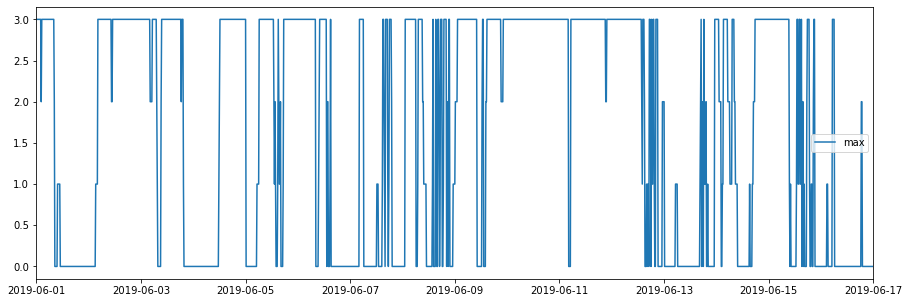

In [33]:
plt.figure(figsize=(15,5))
plt.plot(df_pv_weather['cloudcover_category'],label='max')
plt.legend()
plt.xlim(datetime(2019,6,1),datetime(2019,6,17))

We do not need the cloud data anymore.
Further, we also choose the forego a few other features which we think aren't that useful. For example, There is no snow during Spring/Summer in Belgium and we aren't bothered about the windspeed at any altitude for PV generation.

In [34]:
df_pv_weather_new = df_pv_weather.drop(columns=['CM', 'CD', 'CU', 'RH2m', 'SNOW', 'WS100m', 'WS10m', 'cloudcover'])

In [35]:
df_pv_weather_new.head()

,PV,PREC,ST,SWD,SWDtop,TT2M,cloudcover_category
Time_DT,,,,,,,
2019-05-20 00:00:00,0.0,0.07,10.83,0.0,0,11.32,3
2019-05-20 00:15:00,0.0,0.05,11.30,0.0,0,11.58,3
2019-05-20 00:30:00,0.0,0.05,11.59,0.0,0,11.87,3
2019-05-20 00:45:00,0.0,0.06,11.73,0.0,0,11.99,3
2019-05-20 01:00:00,0.0,0.02,11.84,0.0,0,12.08,3


(18048.166666666668, 18048.916666666668)

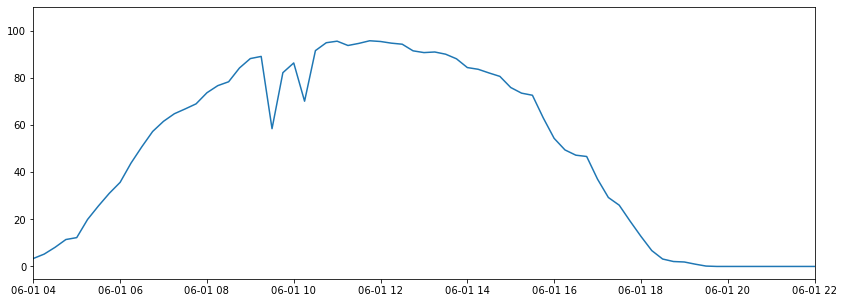

In [36]:
plt.figure(figsize=(14,5))
plt.plot(df_pv_weather['PV'])
plt.xlim(datetime(2019,6,1,4,0,0),datetime(2019,6,1,22,0,0))

#### Data disappointment

The data has been a disappointment to say to the least. It is very short (about a month) and hence makes it difficult for us to really perform much analysis. But we plot on to do some regression and classification on what we got

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
y = df_pv_weather_new['PV'].to_numpy()

In [40]:
x = df_pv_weather_new.copy().drop(columns='PV').to_numpy()

In [43]:
x

array([[0.07, 10.83, 0.0, '0', 11.32, 3],
       [0.05, 11.3, 0.0, '0', 11.58, 3],
       [0.05, 11.59, 0.0, '0', 11.87, 3],
       ...,
       [0.0, 19.71, 0.0, '0', 21.2, 3],
       [0.0, 19.25, 0.0, '0', 20.95, 3],
       [0.0, 17.53, 0.0, '0', 20.42, 3]], dtype=object)

The `x` variable is of type object. And this is because one of the variables is in string format.

In [44]:
def str_to_float(x):
    try:
        y = float(x)
    except:
        y = 0.0
    return y

In [45]:
df_pv_weather_new['SWDtop'] = df_pv_weather_new['SWDtop'].apply(str_to_float)

In [46]:
y = df_pv_weather_new['PV'].to_numpy()
x = df_pv_weather_new.copy().drop(columns='PV').to_numpy()
x

array([[ 0.07, 10.83,  0.  ,  0.  , 11.32,  3.  ],
       [ 0.05, 11.3 ,  0.  ,  0.  , 11.58,  3.  ],
       [ 0.05, 11.59,  0.  ,  0.  , 11.87,  3.  ],
       ...,
       [ 0.  , 19.71,  0.  ,  0.  , 21.2 ,  3.  ],
       [ 0.  , 19.25,  0.  ,  0.  , 20.95,  3.  ],
       [ 0.  , 17.53,  0.  ,  0.  , 20.42,  3.  ]])

Now things look good.

In [47]:
 X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [48]:
X_train

array([[0.0000e+00, 2.5280e+01, 5.0087e+02, 7.3258e+02, 2.1590e+01,
        1.0000e+00],
       [2.0000e-02, 2.2740e+01, 6.1214e+02, 0.0000e+00, 1.9380e+01,
        1.0000e+00],
       [0.0000e+00, 7.3200e+00, 0.0000e+00, 0.0000e+00, 1.0900e+01,
        0.0000e+00],
       ...,
       [1.0000e-02, 1.6680e+01, 3.3000e-01, 7.9800e+00, 1.6800e+01,
        1.0000e+00],
       [4.0000e-02, 1.0710e+01, 0.0000e+00, 0.0000e+00, 1.0340e+01,
        3.0000e+00],
       [1.9000e-01, 1.6300e+01, 0.0000e+00, 0.0000e+00, 1.5850e+01,
        3.0000e+00]])

## Linear Regression

Just to satisfy our curiosities and to see how to use some of the ML modules in Python, we take up linear regression module

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
pv_linreg = LinearRegression()

In [52]:
pv_training_model = pv_linreg.fit(X_train,y_train)

In [53]:
pv_training_model.coef_

array([-3.60458255,  0.47850961,  0.08701709,  0.01136205, -2.31499966,
        2.28694066])

In [54]:
pv_training_model.intercept_

31.11753594957414

In [55]:
y_predict = pv_training_model.predict(X_test)

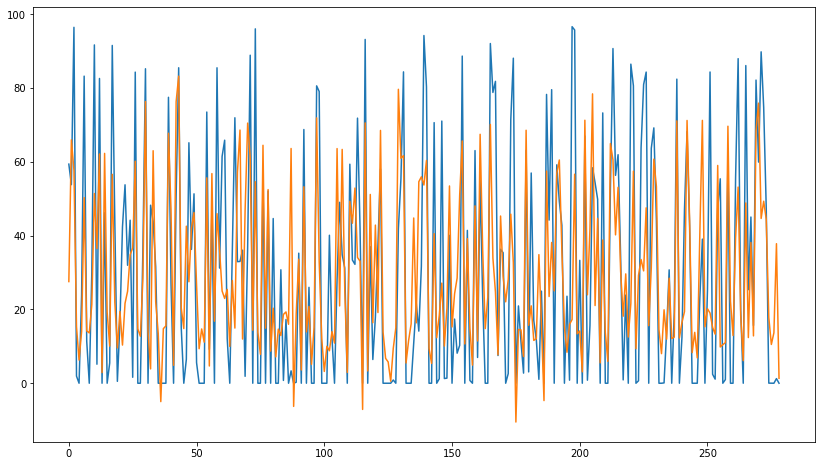

In [56]:
plt.figure(figsize=(14,8))
plt.plot(y_test)
plt.plot(y_predict)


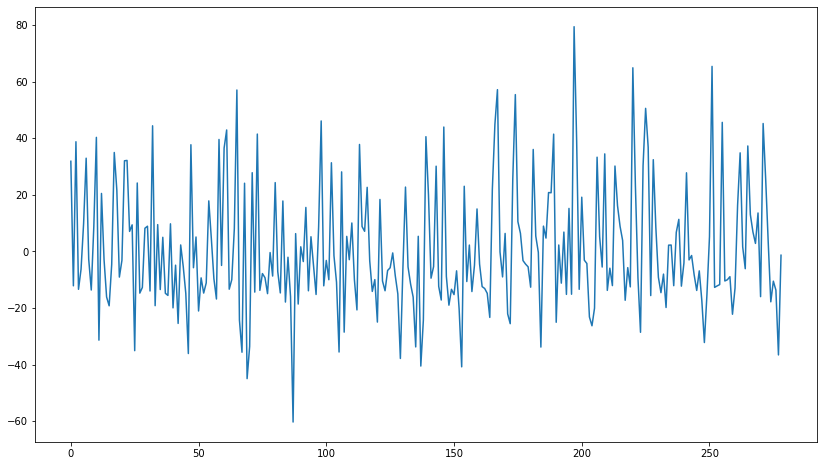

In [57]:
plt.figure(figsize=(14,8))
plt.plot(y_test-y_predict)


The results aren't really pretty. But then, we used a linear regression and over such a short data. And the authors of the origican work used neural networks. So it is fair to say we aren't going to get anywhere.

## Classification
Another simple ML tool to test would be classification. 
To obtain a classification model, we would like to make PV into four classes.

In [58]:
maxval = df_pv_weather_new['PV'].max()
minval = df_pv_weather_new['PV'].min()
def pv_categorize(x):
    if x == minval:
        return 0
    elif x > minval and x < maxval/3.0:
        return 1
    elif x >= maxval/3.0 and x<maxval*2.0/3.0:
        return 2
    else:
        return 3

In [59]:
df_pv_weather_new['PV_cat'] = df_pv_weather_new['PV'].apply(pv_categorize)

In [60]:
df_pv_weather_new['PV_cat'].unique()

array([0, 1, 2, 3], dtype=int64)

In [61]:
y = df_pv_weather_new['PV_cat'].to_numpy()

In [62]:
X = df_pv_weather_new.drop(columns=['PV', 'PV_cat']).to_numpy()

In [63]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

In [65]:
PV_kNN = KNeighborsClassifier(n_neighbors=4)

In [67]:
PV_kNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [68]:
y_predict = PV_kNN.predict(X_test)

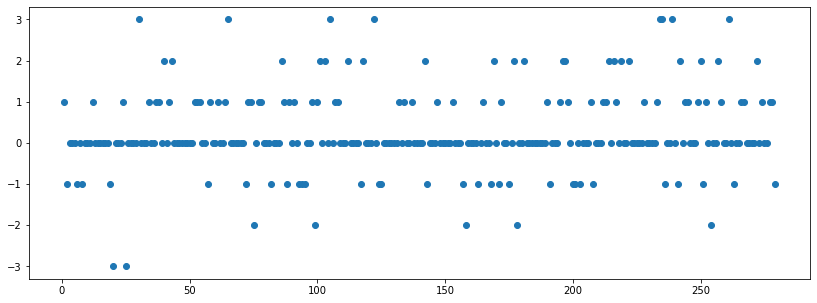

In [69]:
x_dummy = range(1,len(y_test)+1)
plt.figure(figsize=(14,5))
plt.scatter(x_dummy, y_test-y_predict)
#plt.scatter(x_dummy, y_predict)
#plt.xlim([150,200])

In [77]:
print(sum(abs(y_test-y_predict)==0)/len(y_test))
print(sum(abs(y_test-y_predict)==0)/len(y_test) + sum(abs(y_test-y_predict)==1)/len(y_test))

0.5842293906810035
0.8709677419354838


So it appears the result has 58% accuracy and 87% of the results predict within 1 class difference. Which seems good for such a simple classifier